# Art Style Transfer

This notebook is an implementation of the algorithm described in "A Neural Algorithm of Artistic Style" (http://arxiv.org/abs/1508.06576) by Gatys, Ecker and Bethge. Additional details of their method are available at http://arxiv.org/abs/1505.07376 and https://bethgelab.org/deepneuralart/.

An image is generated which combines the content of a photograph with the "style" of a painting. This is accomplished by jointly minimizing the squared difference between feature activation maps of the photo and generated image, and the squared difference of feature correlation between painting and generated image. A total variation penalty is also applied to reduce high frequency noise. 

In [20]:
import sys
import os
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy

from PIL import Image
import cPickle

import theano
import theano.tensor as T

from lasagne.utils import floatX
from collections import OrderedDict

import matplotlib.pyplot as plt

from IPython import display
%matplotlib inline

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGE_W = 600

# Note: tweaked to use average pooling instead of maxpooling
def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, IMAGE_W, IMAGE_W))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')

    return net


# helper functions for all my needs

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

def image2pixelarray(filepath):
    im = Image.open(filepath).convert('RGB')
    (width, height) = im.size
    idata = list(im.getdata())
    idata = np.array(idata)
    idata = idata.reshape((height, width, idata.shape[1]))
    return idata

def progress(i, n, skip=100, mode=1):
    if (i%skip == 0 or n < i + skip) and mode == 1:
        if i + 1 < n:
            out = "\r%s%%" % "{:5.2f}".format(100*i/float(n))
        else:
            out = "\r100%"
        sys.stdout.write(out)
        sys.stdout.flush()

def dump_obj(obj, fname):
    try:
        f = file(fname, 'wb')
        cPickle.dump(obj, f, protocol=cPickle.HIGHEST_PROTOCOL)
        f.close()
        return 1
    except Exception as e:
        print e
        return 0

def load_obj(fname):
    try:
        f = file(fname, 'rb')
        loaded_obj = cPickle.load(f)
        f.close()
        return loaded_obj
    except Exception as e:
        print e
        return 0
    
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def do_train(tr_fn, iterations, outfolder, show=True, autosave=100):
    if not os.path.exists(outfolder):
        os.mkdir(outfolder)
    
    for i in range(iterations):
        loss = tr_fn()
        progress(i, iterations, skip=1)
        if not i%autosave:
            cur = generated_image.get_value().astype('float64')
            dump_obj(cur, os.path.join(outfolder,str(u+i)))
            display.clear_output(wait=True)
            
            s = 'iteration: ' + str(u+i) + ' loss: ' + str(loss)
            h.append(s)
            for i in h[-5:]:
                print i
            
            if show:
                plt.figure(figsize=(12,12))
                plt.imshow(deprocess(cur), interpolation='nearest')
                plt.show()
    
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

In [ ]:
# Download the normalized pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl
# (original source: https://bethgelab.org/deepneuralart/)

!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl

In [21]:
# build VGG net and load weights

net = build_model()
values = pickle.load(open('vgg19_normalized.pkl'))['param values']
lasagne.layers.set_all_param_values(net['pool5'], values)

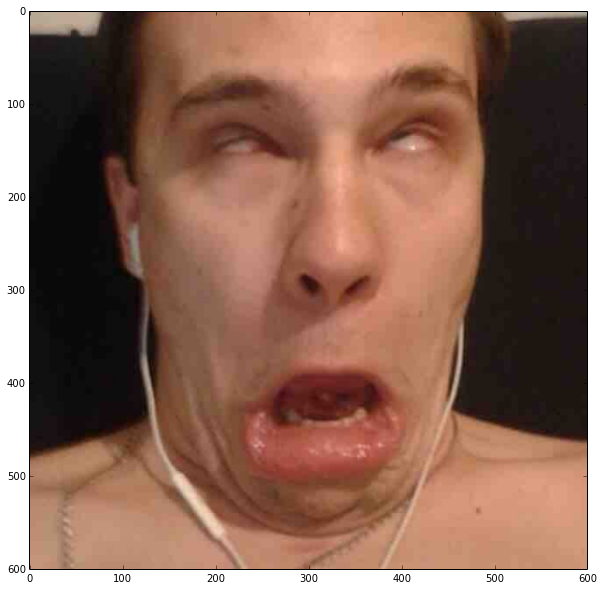

In [84]:
photo = image2pixelarray('artwork/stas.jpg')
rawim, photo = prep_image(photo)
plt.figure(figsize=(10,10))
plt.imshow(rawim)

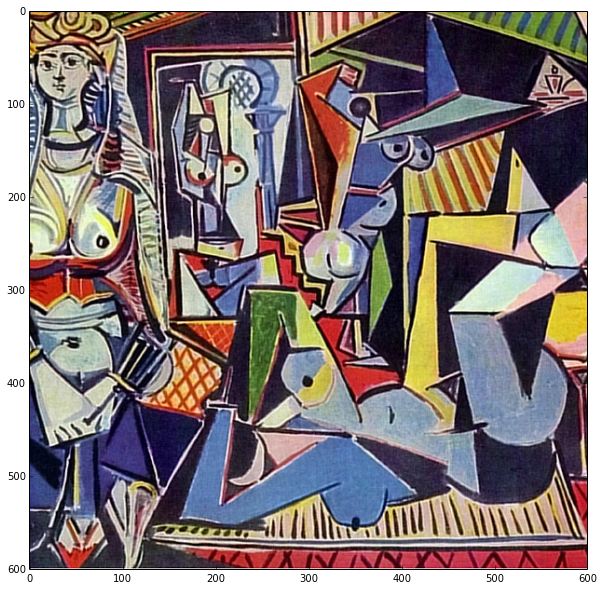

In [74]:
#art = plt.imread('1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
rawim, art = prep_image(image2pixelarray('artwork/femmes.jpg'))
plt.figure(figsize=(10,10))
plt.imshow(rawim)

In [24]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net[k] for k in layers}

In [85]:
# Precompute layer activations for photo and artwork
input_im_theano = T.tensor4()
outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

photo_features = {k: theano.shared(output.eval({input_im_theano: photo}))
                  for k, output in zip(layers.keys(), outputs)}
art_features = {k: theano.shared(output.eval({input_im_theano: art}))
                for k, output in zip(layers.keys(), outputs)}

In [86]:
# we don't need no scipy.optimize.fmin_l_bfgs_b

def adam(grads, params, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):

    all_grads = grads
    t_prev = theano.shared(floatX(0.))
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    t = t_prev + 1
    a_t = learning_rate*T.sqrt(one-beta2**t)/(one-beta1**t)

    for param, g_t in zip(params, all_grads):
        value = param.get_value(borrow=True)
        m_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)
        v_prev = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                               broadcastable=param.broadcastable)

        m_t = beta1*m_prev + (one-beta1)*g_t
        v_t = beta2*v_prev + (one-beta2)*g_t**2
        step = a_t*m_t/(T.sqrt(v_t) + epsilon)

        updates[m_prev] = m_t
        updates[v_prev] = v_t
        updates[param] = param - step

    updates[t_prev] = t
    return updates

In [78]:
def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * T.sum((x - p)**2)
    return loss

def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    # yay fun   
    A = cov_matrix(a) + mean_matrix(a)
    G = cov_matrix(x) + mean_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * T.sum((G - A)**2)
    return loss

def total_variation_loss(x):
    return T.sum(((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25)


def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')


def mean_matrix(x):
    x = x.flatten(ndim=3)
    g = T.mean(x, axis=2)
    return g

def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g

def cov_matrix(x):
    x = x.flatten(ndim=3)
    m = T.mean(x, axis=2)
    x = x - m[:,:,np.newaxis]
    g = T.tensordot(x, x, axes=([2], [2]))
    return g

In [91]:
# Get expressions for layer activations for generated image
generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}

In [93]:
# Define loss function
losses = []

# content loss
losses.append(0.002 * content_loss(photo_features, gen_features, 'conv4_2'))

# style loss
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv1_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv2_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv3_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv4_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv5_1'))

# total variation penalty
losses.append(0.1e-7 * total_variation_loss(generated_image))

total_loss = T.sum(losses)

grad = T.grad(total_loss, generated_image)

# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

upd = adam([grad], [generated_image], learning_rate=5)
train_fn = theano.function([], total_loss, updates=upd, allow_input_downcast=True)

iteration: 4500 loss: 3268.47452242
iteration: 4600 loss: 3055.61923166
iteration: 4700 loss: 2903.57008528
iteration: 4800 loss: 2832.20789039
iteration: 4900 loss: 3450.32225906


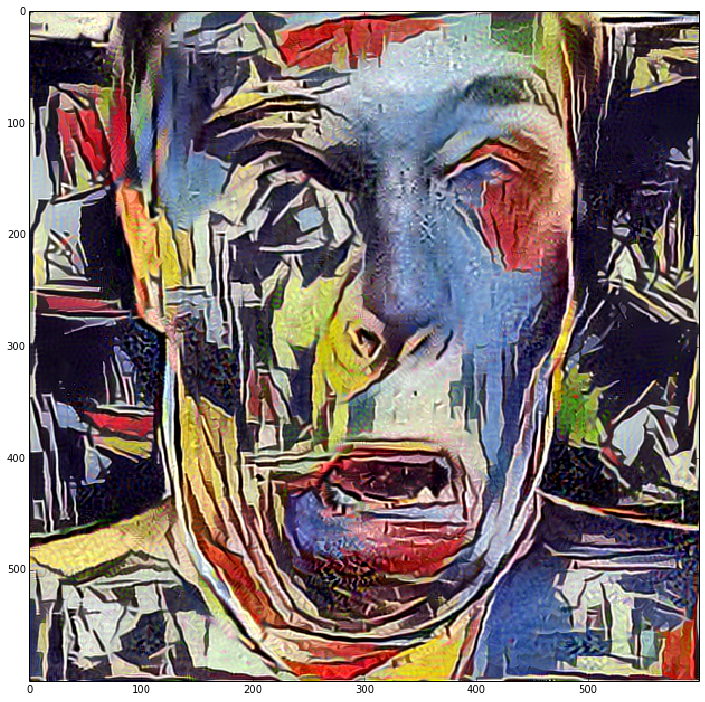

100%

In [94]:
u = 0
h = []
do_train(train_fn, 5000, './output/14')

In [238]:
val = load_obj('output/9/450')
#val[:,:,80:125, 205:238] = photo[:,:,80:125, 205:238]

In [239]:
generated_image = theano.shared(val)

In [ ]:
# Initialize with a noise image
generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(3):
    
    sys.stdout.flush()
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)
    

In [ ]:
# Optimize, saving the result periodically
for i in range(5):
    sys.stdout.flush()
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)
    print 'iteration:', i+1

In [ ]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(xs[i]))
plt.tight_layout()

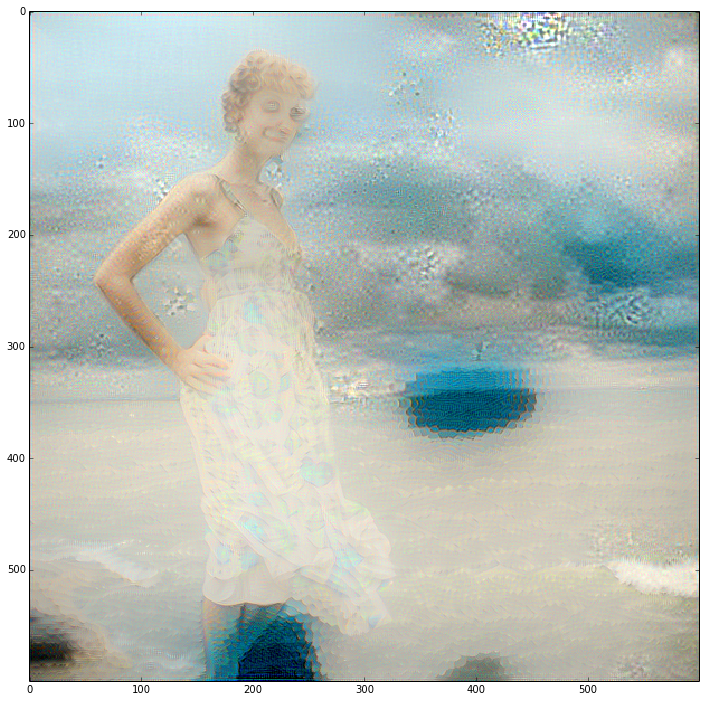

In [48]:
plt.figure(figsize=(12,12))
plt.imshow(deprocess(generated_image.get_value().astype('float64')), interpolation='nearest')

In [ ]:
deprocess(generated_image.get_value().astype('float64'))

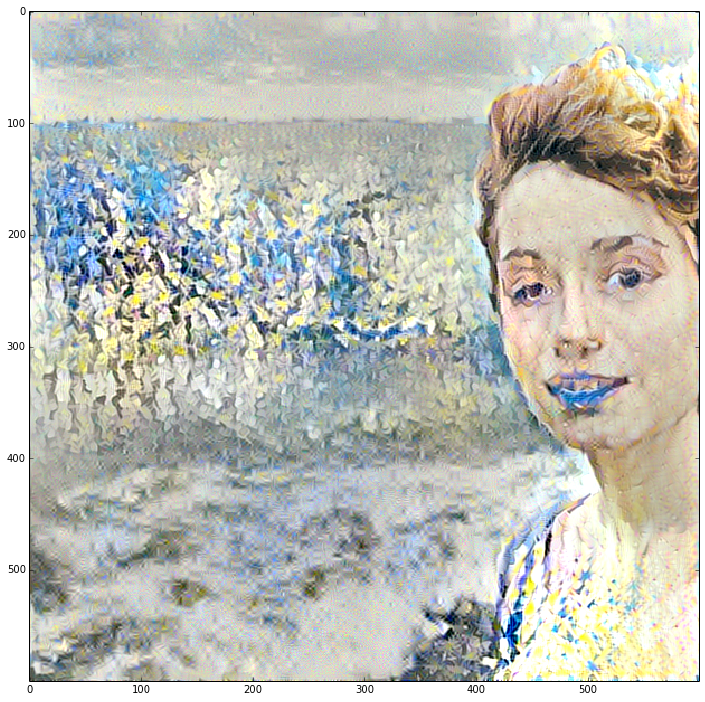

In [402]:
plt.figure(figsize=(12,12))
plt.imshow(deprocess(generated_image.get_value().astype('float64')), interpolation='nearest')